### Import libraries


In [ ]:
#imports 
import os
import glob
import time
import json
from skimage.draw import polygon2mask
import numpy as np
import pandas as pd
import torch
import math
import tqdm.notebook as tqdm 
from PIL import Image
import pytesseract
from pathlib import Path
import subprocess
import cv2
from lxml import etree
import requests
import enchant
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap


from kraken.lib.models import load_any
from kraken import binarization, pageseg, rpred, serialization
from escriptorium_connector import EscriptoriumConnector
from transformers import AutoModelForMaskedLM, AutoTokenizer

### Set up and helper functions


In [ ]:
IMAGE_DIR_DE = "samples_from_ddb"        

# Tesseract: using French (“fra”) OCR model for data from Gallica
TESS_LANG = "fra"

# using Kraken default model
KRAKEN_MODEL_DE ="models/bnl-ocr-fraktur.mlmodel"

In [ ]:
kraken_model = load_any(KRAKEN_MODEL_DE)

In [ ]:


def ocr_krakenDE(img_path):
    """ OCR using Kraken.
    """
    img_path = Path(img_path).resolve()
    ws_dir   = img_path.parent / f"{img_path.stem}_kraken_ws"
    ws_dir.mkdir(exist_ok=True)

    out_txt = ws_dir / f"{img_path.stem}_kraken.txt"
    if out_txt.exists():
        return out_txt                    # already processed

    cmd = [
        "kraken", "-i", str(img_path), str(out_txt),
        "binarize", "segment", "-bl", "-d", "horizontal-lr",
        "ocr", "-m", KRAKEN_MODEL
    ]

    if subprocess.run(cmd).returncode != 0 or not out_txt.exists():
        print(f"Kraken failed on {img_path.name}")
        return None

    return out_txt

def ocr_ocrd_tesseract_calamariDE(img_path):
	img_path = Path(img_path).resolve()
	ws_dir = img_path.parent / f"{img_path.stem}_ocrd_ws"
	ws_dir.mkdir(exist_ok=True)

	# ------------------------------------------------------------------
	# phase 0  – workspace + image
	# ------------------------------------------------------------------
	if not (ws_dir / "mets.xml").exists():
		subprocess.run(["ocrd", "workspace", "--directory", ws_dir, "init"],
					   check=True)

	subprocess.run([
		"ocrd", "workspace", "--directory", ws_dir,
		"add", "-g", "PAGE1", "-i", "OCR-D-IMG_PAGE1",
		"-m", "image/tiff", "-G", "OCR-D-IMG", "--force",
		str(img_path)
	], check=True)

	# ------------------------------------------------------------------
	# phase 1  – binarise + segment (shared for both engines)
	# ------------------------------------------------------------------
	subprocess.run(["ocrd-olena-binarize",
					"-I", "OCR-D-IMG", "-O", "OCR-D-BIN", "--overwrite"],
				   cwd=ws_dir, check=True)

	subprocess.run(["ocrd-tesserocr-segment",
					"-I", "OCR-D-BIN", "-O", "OCR-D-SEG", "--overwrite"],
				   cwd=ws_dir, check=True)

	# ------------------------------------------------------------------
	# phase 2a – recognise with Tesseract
	# ------------------------------------------------------------------
	subprocess.run([
		"ocrd-tesserocr-recognize",
		"-I", "OCR-D-SEG", "-O", "OCR-D-OCR-TESSEROCR",
		"-p", '{"model": "Fraktur_GT4HistOCR"}',
		"--overwrite"
	], cwd=ws_dir, check=True)

	subprocess.run([
		"ocrd-fileformat-transform",
		"-I", "OCR-D-OCR-TESSEROCR", "-O", "OCR-D-TXT",
		"-P", "from-to", "page text", "--overwrite"
	], cwd=ws_dir, check=True)

	# ------------------------------------------------------------------
	# phase 2b – recognise with Calamari
	# ------------------------------------------------------------------
	subprocess.run([
		"conda", "run", "-n", "ds-calamari",
		"ocrd-calamari-recognize",
		"-I", "OCR-D-SEG", "-O", "OCR-D-OCR-CALAMARI",
		"-P", "checkpoint_dir", "gt4histocr",
		"--overwrite"
	], cwd=ws_dir, check=True)

	subprocess.run([
		"ocrd-fileformat-transform",
		"-I", "OCR-D-OCR-CALAMARI", "-O", "OCR-D-TXT-CALAMARI",
		"-P", "from-to", "page text", "--overwrite"
	], cwd=ws_dir, check=True)

	# ------------------------------------------------------------------
	# Collect output paths
	# ------------------------------------------------------------------
	tesseract_txt = ws_dir / "OCR-D-TXT" / "OCR-D-TXT_PAGE1.txt"
	calamari_txt = ws_dir / "OCR-D-TXT-CALAMARI" / "OCR-D-TXT-CALAMARI_PAGE1.txt"

	return tesseract_txt, calamari_txt

In [ ]:
image_paths = sorted(
    glob.glob(os.path.join(IMAGE_DIR_DE, "*.*")),
    key=lambda p: p.lower()
)
image_paths = [Path(p) for p in image_paths if p.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))]

if not image_paths:
    raise FileNotFoundError(f"No images found in {IMAGE_DIR_DE}")




### Run OCRs

In [ ]:
text_results_paths = []
i = 0
for img_path in image_paths:
    print(f"Processing {img_path}")
    
    tess_txt, cala_txt = ocr_ocrd_tesseract_calamari(img_path)  
    kraken_txt         = ocr_kraken(img_path)
    if i == 0:
        ddb_txt = Path("samples_from_ddb/BT.txt")
    if i == 1:
        ddb_txt = Path("samples_from_ddb/NAZ.txt")
    i += 1
    text_results_paths.append({
        "image":        img_path.name,
        "tesseract":    tess_txt,
        "kraken":       kraken_txt,
        "ocrd_calamari": cala_txt,
        "ddb":          ddb_txt
        
    })

Processing samples_from_ddb/BT.jpeg


NameError: name 'ocr_ocrd_tesseract_calamari' is not defined

### Perplexity and OOV rate calculation

In [ ]:

hf_model_id = "dbmdz/bert-base-german-cased" 
device      = "cuda:0" if torch.cuda.is_available() else "cpu"


print(f"Loading {hf_model_id} on {device} …")
tokenizer = AutoTokenizer.from_pretrained(hf_model_id)
model     = AutoModelForMaskedLM.from_pretrained(hf_model_id).to(device)
model.eval()


def sliding_windows(tokens, max_len, stride):
    for start in range(0, len(tokens), stride):
        window = tokens[start : start + max_len]
        if len(window) < max_len:
            break
        yield window

def perplexity(text: str, max_len=256, stride=128) -> float:
    enc = tokenizer(text, return_tensors="pt")["input_ids"][0]
    losses = []
    with torch.no_grad():
        for window in sliding_windows(enc, max_len, stride):
            inputs   = window.unsqueeze(0).to(device)
            labels   = inputs.clone()
            outputs  = model(inputs, labels=labels)
            loss     = outputs.loss.item()
            losses.append(loss)
    if sum(losses) == 0 or len(losses) == 0:
        return float("inf")
    return math.exp(sum(losses) / len(losses))


de_dict = enchant.Dict("de_DE")  # German dictionary for Fraktur text

def get_oov_rate(text: str) -> float:
    words = text.split()
    if len(words) == 0:
        return float("inf")  # no words, return infinity
    oov = sum(1 for w in words if not de_dict.check(w))
    if oov == 0:
        return float("inf")  # no OOV words, return infinity
    return oov / len(words)
records = []
def get_iv_rate(text: str) -> float:
    words = text.split()
    if len(words) == 0:
        return float("inf")  # no words, return infinity
    iv = sum(1 for w in words if de_dict.check(w))
    if iv == 0:
        return float("inf")  # no in-vocabulary words, return infinity
    return iv / len(words) , iv



Loading dbmdz/bert-base-german-cased on cpu …


Some weights of the model checkpoint at dbmdz/bert-base-german-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluating OCR texts:   0%|          | 0/2 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4326 > 512). Running this sequence through the model will result in indexing errors


,file,perplexity_tesseract,perplexity_kraken,perplexity_calamari,perplexity_ddb,oov_tesseract,oov_kraken,oov_calamari,oov_ddb,iv_rate_tesseract,iv_tesseract,iv_rate_kraken,iv_kraken,iv_rate_calamari,iv_calamari,iv_rate_ddb,iv_ddb
0,BT,2.078431,2.230584,2.170074,1.434679,0.508929,0.765734,0.806562,0.257819,0.491071,1320,0.234266,335,0.193438,454,0.742181,1851
1,NAZ,2.382626,2.273165,1.963034,1.534843,0.597640,0.730213,0.745175,0.319173,0.402360,1671,0.269787,317,0.254825,977,0.680827,2436


In [ ]:
records = []
for txt_path in tqdm(text_results_paths, desc="Evaluating OCR texts"):
    text_tesseract = txt_path["tesseract"].read_text(encoding="utf-8", errors="ignore")
    text_kraken    = txt_path["kraken"].read_text(encoding="utf-8", errors="ignore")
    text_calamari  = txt_path["ocrd_calamari"].read_text(encoding="utf-8", errors="ignore")
    text_ddb  = txt_path["ddb"].read_text(encoding="utf-8", errors="ignore")
    # Calculate perplexity for each text
    ppl_tesseract = perplexity(text_tesseract)
    ppl_kraken    = perplexity(text_kraken)
    ppl_calamari  = perplexity(text_calamari)
    ppl_ddb       = perplexity(text_ddb)
    file_name = (Path(txt_path["image"]).stem)
    #calculate oov rate for each text
    oov_tesseract = get_oov_rate(text_tesseract)
    oov_kraken    = get_oov_rate(text_kraken)
    oov_calamari  = get_oov_rate(text_calamari)
    oov_ddb       = get_oov_rate(text_ddb)
    
    #calculate iv rate for each text
    iv_rate_tesseract, iv_tesseract = get_iv_rate(text_tesseract)
    iv_rate_kraken, iv_kraken = get_iv_rate(text_kraken)
    iv_rate_calamari, iv_calamari = get_iv_rate(text_calamari)
    iv_rate_ddb, iv_ddb = get_iv_rate(text_ddb)
    
    records.append({
        "file": file_name,
        "perplexity_tesseract": ppl_tesseract,
        "perplexity_kraken": ppl_kraken,
        "perplexity_calamari": ppl_calamari,
        "perplexity_ddb": ppl_ddb,
        "oov_tesseract": oov_tesseract,
        "oov_kraken": oov_kraken,
        "oov_calamari": oov_calamari,
        "oov_ddb": oov_ddb,
        "iv_rate_tesseract": iv_rate_tesseract,
        "iv_tesseract": iv_tesseract,
        "iv_rate_kraken": iv_rate_kraken,   
        "iv_kraken": iv_kraken,
        "iv_rate_calamari": iv_rate_calamari,
        "iv_calamari": iv_calamari,
        "iv_rate_ddb": iv_rate_ddb,
        "iv_ddb": iv_ddb
    })
df = pd.DataFrame(records).sort_values("perplexity_tesseract")
df

### Visualize OCR comparison

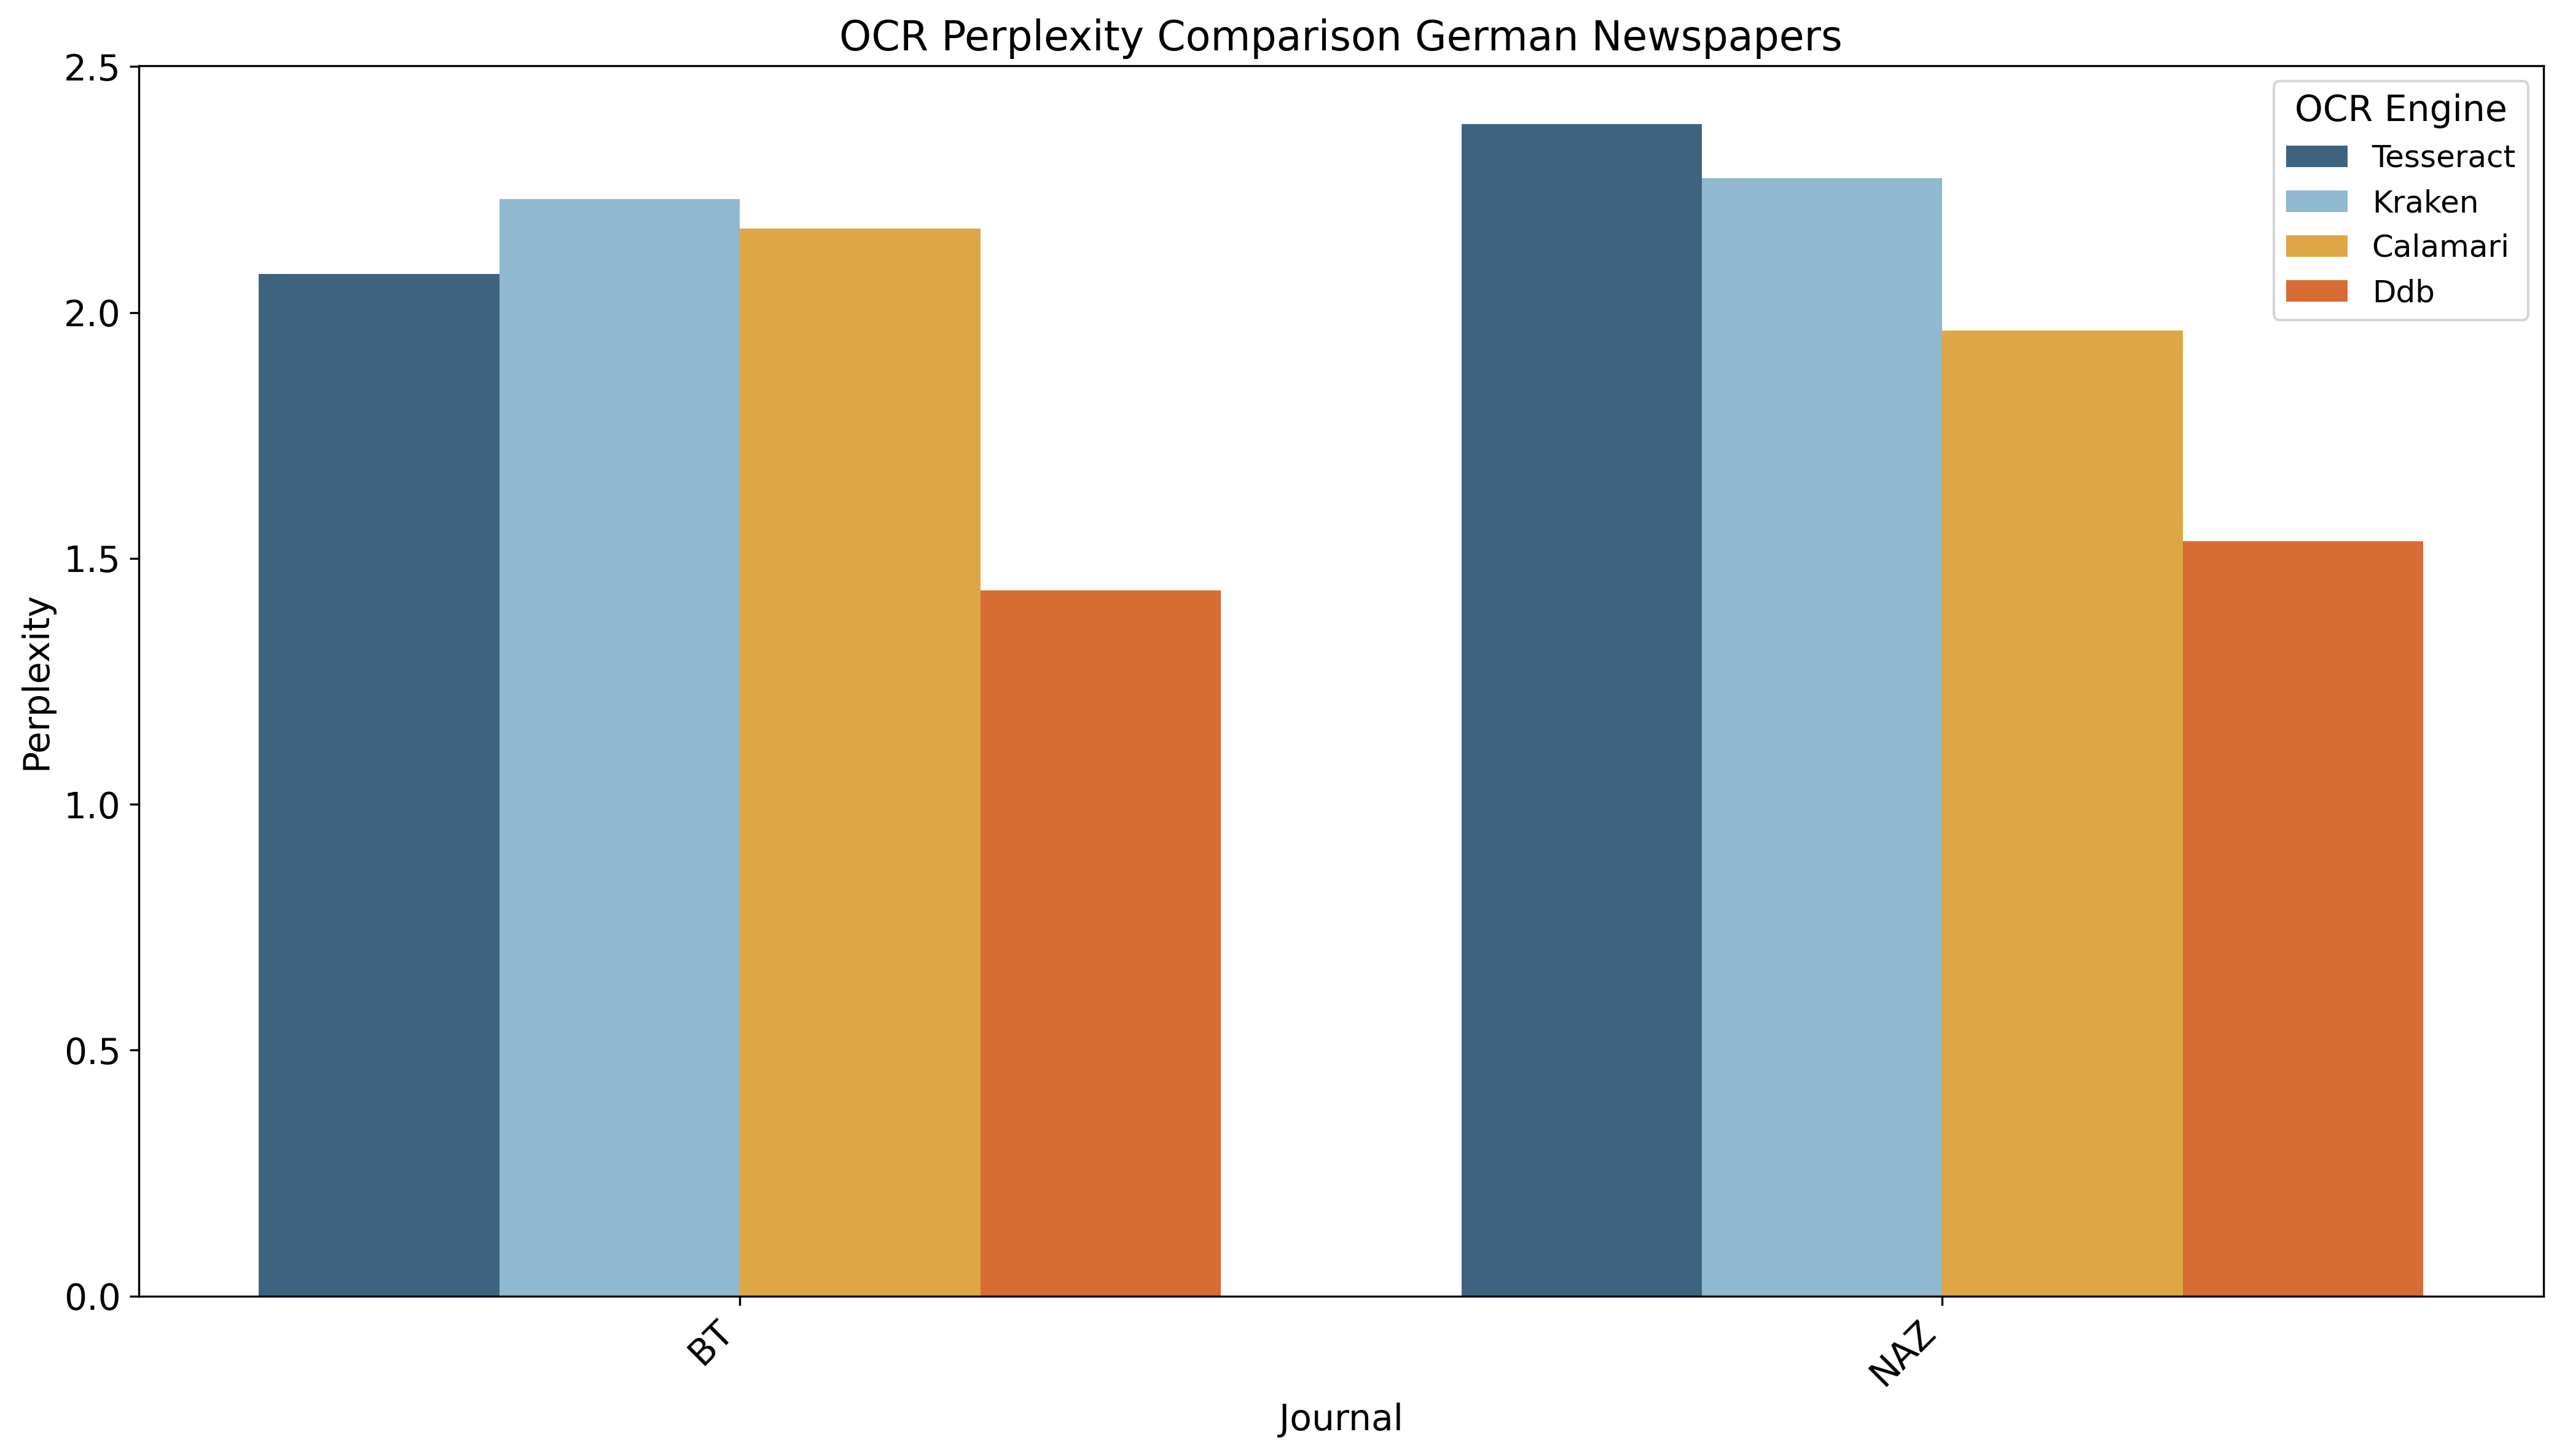

In [ ]:

long = (
    df                                   
    .melt(id_vars="file",
          value_vars=["perplexity_tesseract",
                      "perplexity_kraken",
                      "perplexity_calamari", "perplexity_ddb"],
          var_name="engine",
          value_name="perplexity")
    .assign(engine=lambda d: d.engine.str.replace(r"perplexity_", "", regex=True)
                                      .str.capitalize())  
)

palette = {"Tesseract": "#33658a",  
           "Kraken":     "#86bbd8",  
           "Calamari":   "#f6ae2d",  
           "Ddb":    "#f26419"}     
 
plt.figure(figsize=(14, 8), dpi=300)
sns.barplot(data=long, x="file", y="perplexity",
            hue="engine", palette=palette)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title="OCR Engine", fontsize=12, title_fontsize=14)

labels = [textwrap.fill(f, width=25) for f in long["file"].unique()]
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha="right")

plt.xlabel("Journal", fontsize=14)
plt.ylabel("Perplexity", fontsize=14)
plt.title("OCR Perplexity Comparison German Newspapers", fontsize=16)
plt.tight_layout()
plt.show()


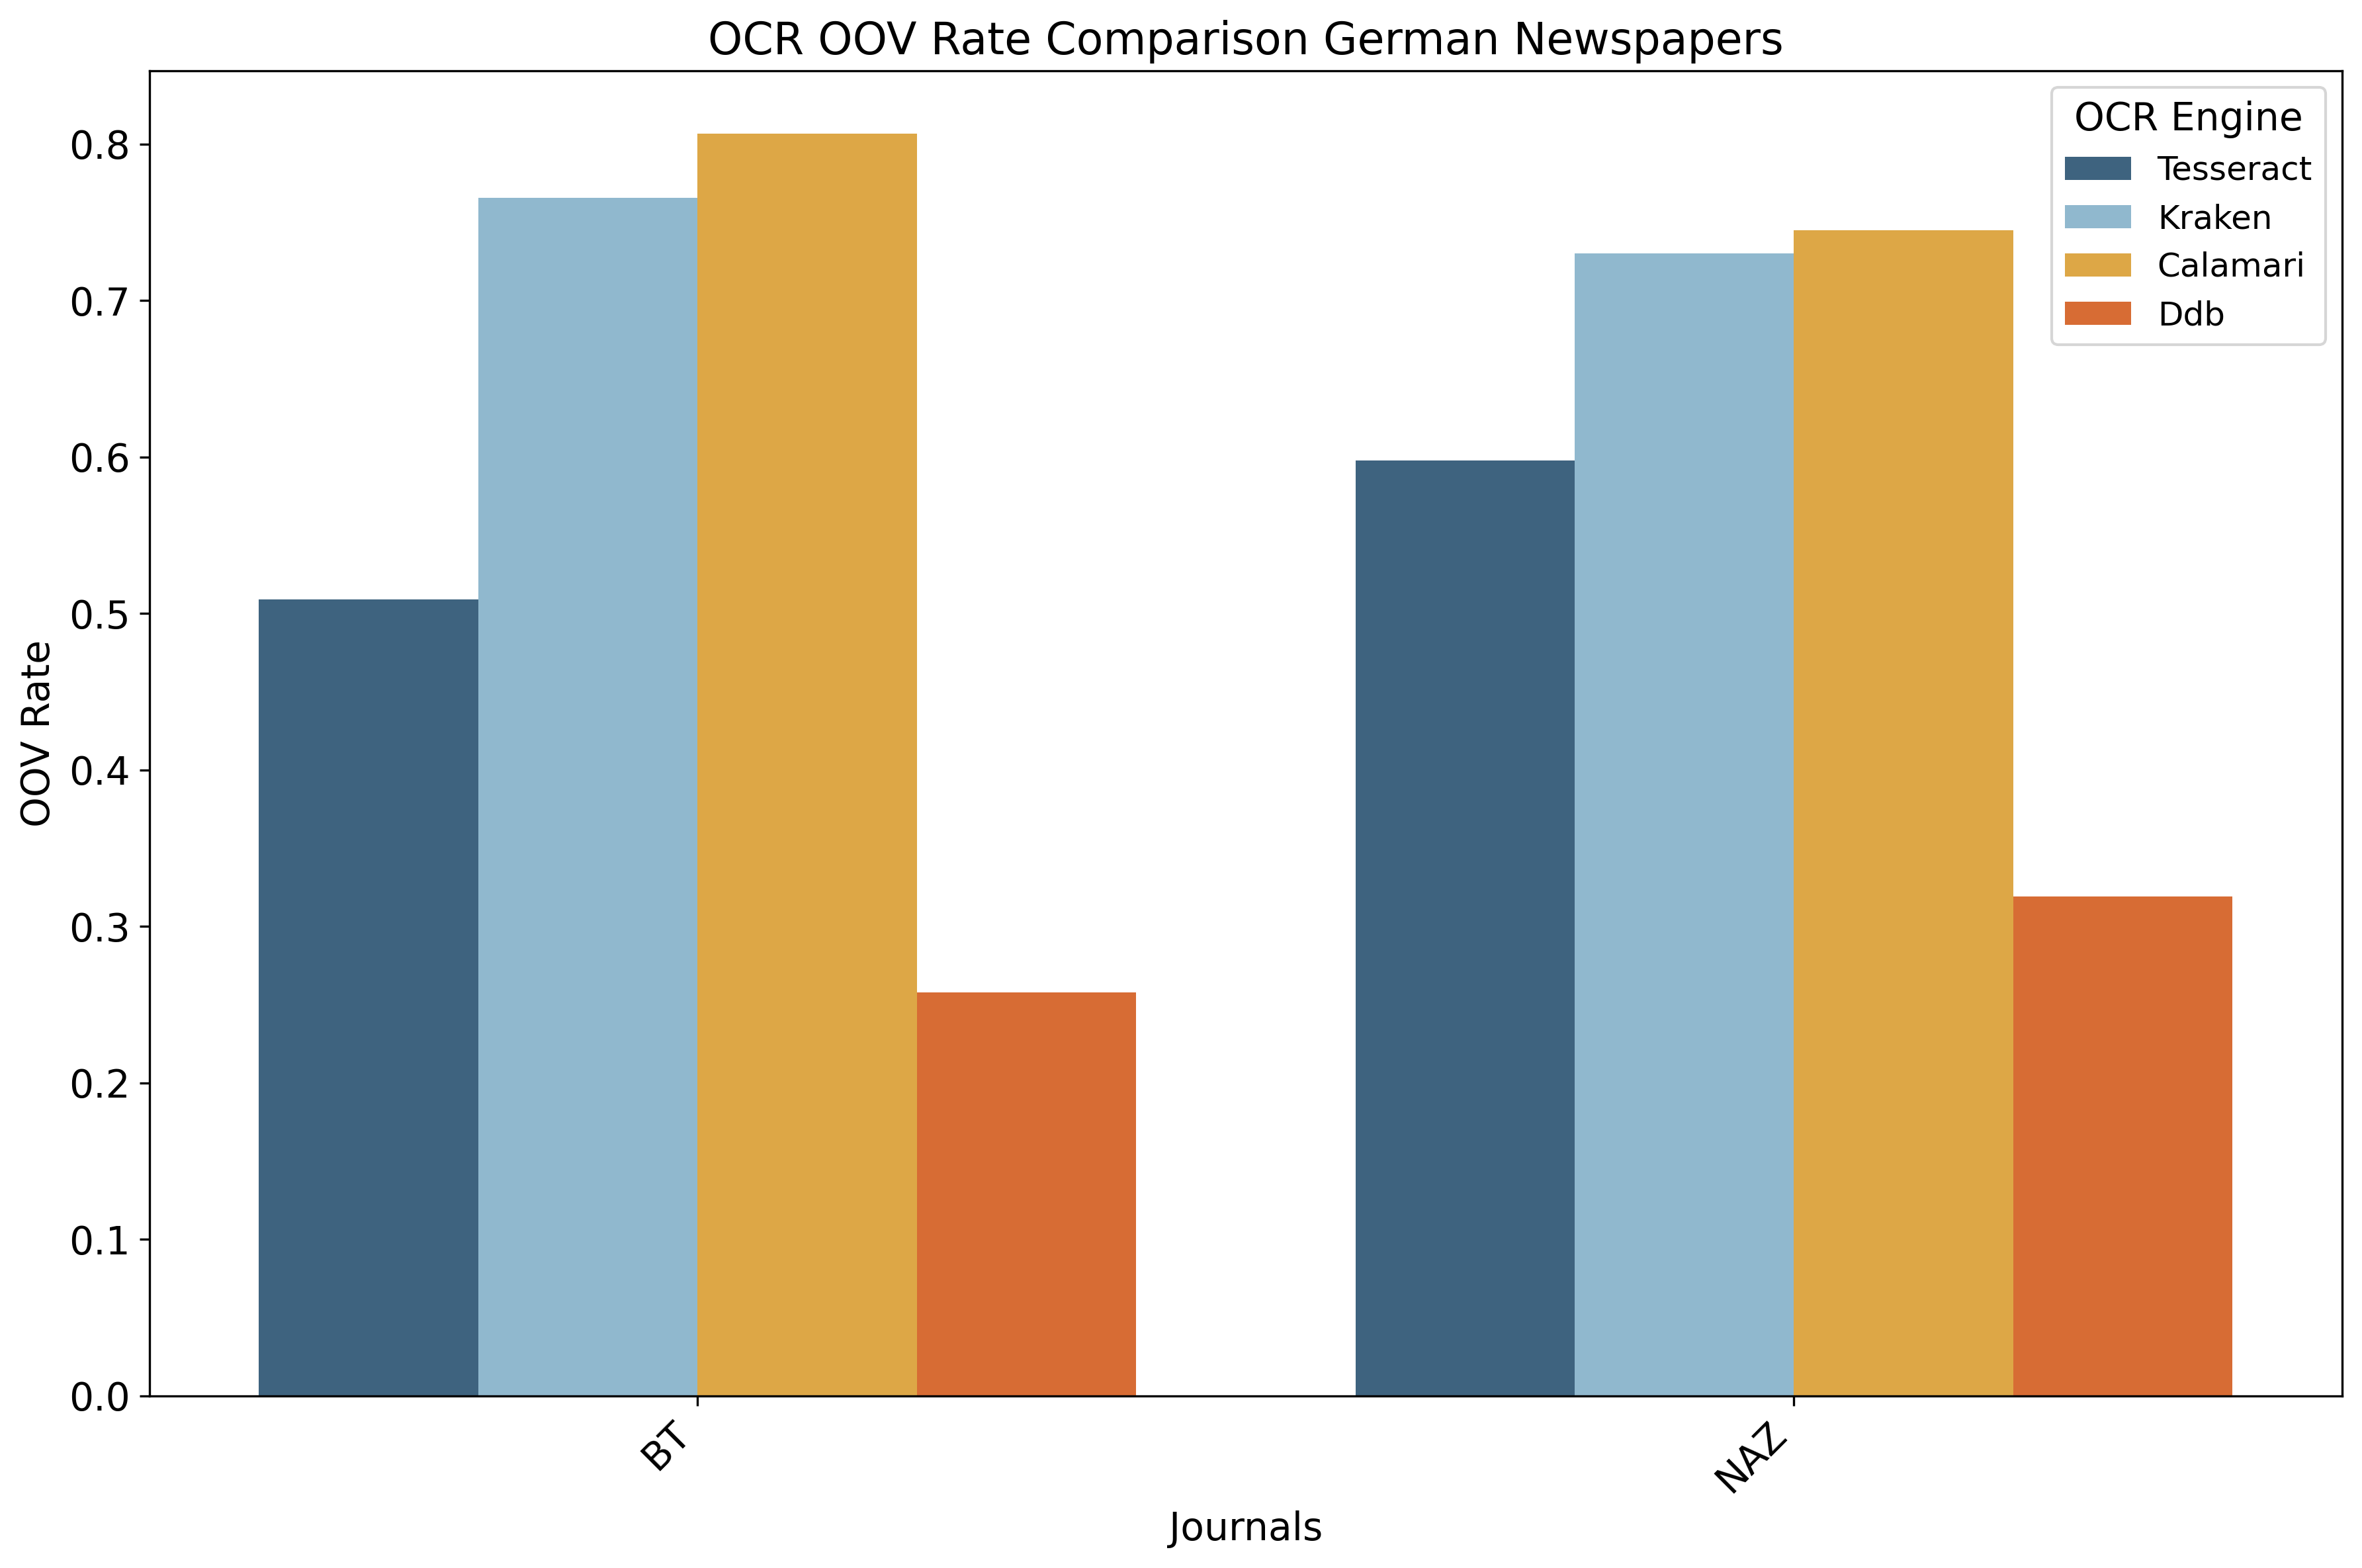

In [ ]:

df = df.sort_values("oov_tesseract")

long = (
    df                                 
    .melt(id_vars="file",
          value_vars=["oov_tesseract",
                      "oov_kraken",
                      "oov_calamari", "oov_ddb"],
          var_name="engine",
          value_name="oov_rate")
    .assign(engine=lambda d: d.engine.str.replace(r"oov_", "", regex=True)
                                      .str.capitalize())  
)


palette = {"Tesseract": "#33658a",  
           "Kraken":     "#86bbd8",  
           "Calamari":   "#f6ae2d",  
           "Ddb":    "#f26419"
        }     

plt.figure(figsize=(12, 8), dpi=300)
sns.barplot(data=long, x="file", y="oov_rate",
            hue="engine", palette=palette)

labels = [textwrap.fill(f, width=25) for f in long["file"].unique()]
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha="right")

plt.legend(title="OCR Engine", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.xlabel("Journals", fontsize=14)
plt.ylabel("OOV Rate", fontsize=14)
plt.title("OCR OOV Rate Comparison German Newspapers", fontsize=16)
plt.tight_layout()
plt.show()
